Plot example neural trajectory in 3-dimension. Population activity is projected on `N` randomly chosen axes (`N` being the number of cells).

In [1]:
import os
from glob import glob
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
plt.style.use('figure.mplstyle')

from function.data2p import get_data_bis
import function.tuning_function as tf
from function.utils import sort_tuning

In [2]:
folder = r'D:\LW_Alldata\SI_Transient'
alldata = {'Enriched': glob(os.path.join(folder,'Enriched*.hdf5')),
           'Dissimilar': glob(os.path.join(folder,'Distinct*.hdf5')),
           'Similar': glob(os.path.join(folder,'Similar*.hdf5'))}
p = 0
exps = ['Enriched','Dissimilar','Similar']
datapath = alldata[exps[p]][2]
day = 1  # Recording days, None for all days
min_rate = 1/60  # Minimum transient rate for active cells
ybin = 160  # Number of spatial bins
ysigma = 2  # Size of the Gaussian filter (in number of spatial bin) for smoothing the tuning curves

In [3]:
data, cells, days, ctx, selected_cells = get_data_bis(
    datapath, day=day, min_rate=0, select='or', verbose=True)  # Pick up all cells first

with h5py.File(datapath, 'r') as f:
    yrange = f['params/yrange'][()]  # Dataset dependent

ncell = data['F'][0].shape[0]    
print('Recording days:', days)
print('Context fam/nov:', ctx)

------------------------------------
Total cells: 91
Active cells: 90
Proportion of active cells 98.90 %
Active in both 97.80 %
Active exclusively in Fam 1.10 %
Active exclusively in Nov 0.00 %
------------------------------------
Recording days: [1 1 1 1]
Context fam/nov: [0 1 0 1]


In [4]:
c = 0  # Fam/Nov
active = (cells['trate'][:,c] >= min_rate)  # Pick up active cells in the specified context

sess = np.where(ctx==c)[0]
moving = np.hstack([data['moving'][s] for s in sess])
F = np.hstack([data['F'][s] for s in sess])[:,moving]
Tr = np.hstack([data['Tr'][s] for s in sess])[:,moving]
y = np.hstack([data['y'][s] for s in sess])[moving]
tuning = tf.tuning_1d(F[active]*Tr[active], y, yrange=yrange, ybin=ybin)[1]
tuning[np.isnan(tuning)] = 0
tuning = gaussian_filter1d(tuning, ysigma, axis=1, mode='nearest')

print('Number of active cells : %d' % np.sum(active))

Number of active cells : 54


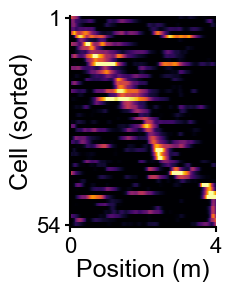

In [5]:
A = tuning  # Shape (N,T) where T is the number of spatial bins
N = A.shape[0]
A2, order = sort_tuning(A, ysigma=0)
y2 = np.linspace(0,4,ybin)

fig, ax = plt.subplots(figsize=(2.6,3.2))
vmax = np.percentile(A2.ravel(), 99)
ax.imshow(A2, interpolation='none', cmap='inferno', vmin=0, vmax=vmax, extent=[0,4,N+0.5,0.5])
ax.set(xticks=[0,4], xticklabels=[0,4], xlabel='Position (m)',
       yticks=[N,1], yticklabels=[N,1], ylabel='Cell (sorted)')
ax.set_aspect('auto')
fig.tight_layout()
# fig.savefig('Example population (1).svg')

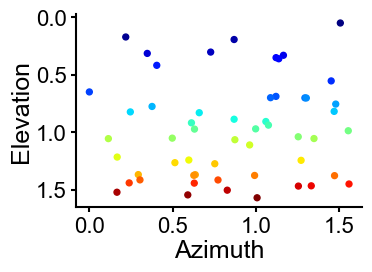

In [35]:
# %% Randomly sampled points on a sphere
rng = np.random.default_rng(5)
U = rng.random(N)
theta = np.arccos(1-U)
phi = rng.random(N)*np.pi/2
# ind = np.argsort(theta + phi)
# ind = np.argsort(theta**2 + phi)
ind = np.argsort(theta)

fig, ax = plt.subplots(figsize=(4,3))
ax.invert_yaxis()
ax.scatter(phi[ind], theta[ind], s=18, c=np.arange(N), cmap='jet')
ax.set(xlabel='Azimuth', ylabel='Elevation')
fig.tight_layout()

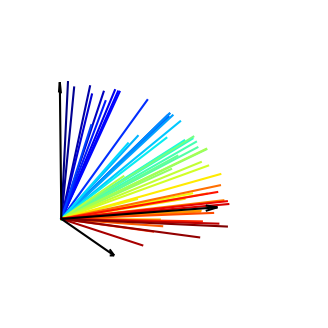

In [87]:
# %% Randomly sampled axes in 3D with uniformly distributed points on a sphere
P = np.vstack([np.sin(theta[ind])*np.cos(phi[ind]),
               np.sin(theta[ind])*np.sin(phi[ind]),
               np.cos(theta[ind])])  # Shape (3,N)

fig, ax = plt.subplots(figsize=(5,4), subplot_kw={'projection':'3d'})
ax.set_axis_off()
origine = np.zeros((3,1))
colors = plt.cm.jet(np.linspace(0,1,N))
for n in range(P.shape[1]):
    segment = np.hstack([origine, P[:,range(n,n+1)]])
    ax.plot(*segment, c=colors[n], rasterized=True)

## Plot orthogonal axis
u1, v1, w1 = np.zeros((3,3))
u2, v2, w2 = 1.0*np.eye(3)
ax.quiver(u1,v1,w1,u2,v2,w2, arrow_length_ratio=0.08, color='k')

ax.view_init(elev=10, azim=-20)
fig.savefig('Example population (2).svg', dpi=200)

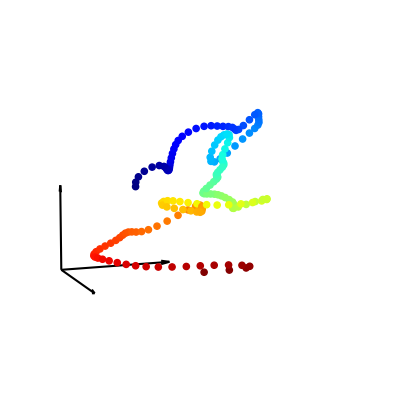

In [89]:
B = P @ A2  # Shape (3,T) where T is the number of spatial bins

fig, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(projection='3d'))
ax.set_axis_off()
ax.scatter(B[0], B[1], B[2], c=y2, cmap='jet', depthshade=0, rasterized=True) 
ax.set(xlim=[0,2], ylim=[0,2], zlim=[0,2])

## Plot orthogonal axis
u1, v1, w1 = np.zeros((3,3))
u2, v2, w2 = 1.0*np.eye(3)
ax.quiver(u1,v1,w1,u2,v2,w2, arrow_length_ratio=0.08, color='k')

ax.view_init(elev=10, azim=-20)
fig.savefig('Example population (3).svg', dpi=200)